# 第6章: 機械学習
本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

## 50. データの入手・整形

News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
3. 抽出された事例をランダムに並び替える．
4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

news_corpora = "NewsAggregatorDataset/newsCorpora.csv"
columns = ["ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY", "HOSTNAME", "TIMESTAMP"]

df = pd.read_csv(news_corpora, delimiter="\t", header=None, index_col=0, names=columns)

target_publisher = ["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"]
df = df[df["PUBLISHER"].isin(target_publisher)]

# https://stackoverflow.com/questions/15772009/shuffling-permutating-a-dataframe-in-pandas
df = df.reindex(np.random.permutation(df.index))

df_size = len(df)
train_size, valid_test_size = int(df_size*0.8), int(df_size*0.1)
assert df_size == train_size + valid_test_size * 2

df_train = df.iloc[:train_size].reset_index(drop=True)
df_valid = df.iloc[train_size:train_size+valid_test_size].reset_index(drop=True)
df_test = df.iloc[train_size+valid_test_size:].reset_index(drop=True)

df_train[["CATEGORY", "TITLE"]].to_csv("train.txt", index=False, sep="\t", encoding="utf-8")
df_valid[["CATEGORY", "TITLE"]].to_csv("valid.txt", index=False, sep="\t", encoding="utf-8")
df_test[["CATEGORY", "TITLE"]].to_csv("test.txt", index=False, sep="\t", encoding="utf-8")

In [2]:
df_train.shape, df_valid.shape, df_test.shape

((10672, 7), (1334, 7), (1334, 7))

## 51. 特徴量抽出

学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [3]:
import spacy
nlp = spacy.load("en_core_web_sm")

# https://universaldependencies.org/docs/u/pos/
open_class_words = ["ADJ", "ADV", "INTJ", "NOUN", "PROPN", "VERB"]

label2int = {
    "b": 0,
    "t": 1,
    "e": 2,
    "m": 3
}
int2label = {i:label for label, i in label2int.items()}

In [4]:
# 入力された Title の DataSeries から Vocabulary を作成
def makeVocab(dataseries, threshold=10):
    vocab2int, int2vocab = {}, {}
    vocab_count = {}
    
    for token in [token for title in dataseries for token in nlp(title.lower())]:
        if token.pos_ in open_class_words:
            if token.lemma_ not in vocab_count.keys():
                vocab_count[token.lemma_] = 1
            else:
                vocab_count[token.lemma_] += 1

    index = 0    
    for word, count in vocab_count.items():
        if count > threshold:
            vocab2int[word] = index
            int2vocab[index] = word
            index += 1

    return vocab2int, int2vocab

In [5]:
# Bag-of-Words を作る
def makeBOW(dataseries, vocab2int):
    bow = []
    
    for title in dataseries:
        current_bag = [0] * (len(vocab2int) + 1)

        for token in nlp(title.lower()):
            if token.pos_ in open_class_words:
                if token.lemma_ in vocab2int.keys():
                    current_bag[vocab2int[token.lemma_]] += 1
                else:
                    current_bag[-1] += 1

        bow.append(current_bag)
    
    return bow

In [6]:
datasets, labels = {}, {}

for each in ['train', 'valid', 'test']:    
    if each == 'train':
        vocab2int, int2vocab = makeVocab(df_train["TITLE"], 15)
        df = df_train
    elif each == 'valid':
        df = df_valid
    elif each == 'test':
        df = df_test
        
    one_hot_publisher = pd.get_dummies(df['PUBLISHER'])
    
    bow_list = makeBOW(df["TITLE"], vocab2int)
    bow_df = pd.DataFrame(bow_list, columns=list(vocab2int.keys())+['UNK'])

    datasets[each] = bow_df.join(one_hot_publisher)
    datasets[each].to_csv(each + ".feature.txt", index=False, sep="\t", encoding="utf-8")
    
    intlabel = []
    for label in df["CATEGORY"]:
        # (b = business, t = science and technology, e = entertainment, m = health)
        intlabel.append(label2int[label])
        
    labels[each] = pd.Series(intlabel)

features = datasets["train"].columns.tolist()

## 52. 学習

51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [7]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver="lbfgs", max_iter=5000, verbose=1, n_jobs=-1)
clf.fit(datasets["train"], labels["train"])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.4s finished


LogisticRegression(max_iter=5000, n_jobs=-1, verbose=1)

## 53. 予測

52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [8]:
text_title_e = "New South Park season will come soon!"
text_title_t = "Next iPhone might have USB-C"
text_title_b = "Boeing 777 operation stops due to engine problem"
text_title_m = "New vaccine for covid 19 have developed"

publishers = ["Businessweek", "Contactmusic.com", "Daily Mail", "Huffington Post", "Reuters"]
onehot_publisher_bw = [1,0,0,0,0] # Businessweek
onehot_publisher_cm = [0,1,0,0,0] # Contactmusic.com
onehot_publisher_dm = [0,0,1,0,0] # Daily Mail
onehot_publisher_hp = [0,0,0,1,0] # Huffington Post
onehot_publisher_rt = [0,0,0,0,1] # Reuters

given_inputs = [
    [text_title_e] + onehot_publisher_dm, 
    [text_title_t] + onehot_publisher_bw,
    [text_title_b] + onehot_publisher_rt,
    [text_title_m] + onehot_publisher_hp
]

given_dfs = pd.DataFrame([])
for label, given_input in zip(["e", "t", "b", "m"], given_inputs):
    bow_list = makeBOW([given_input[0]], vocab2int)
    converted_given = [bow_list[0] + given_input[1:]]
    given_df = pd.DataFrame(
        converted_given, 
        columns=list(vocab2int.keys())+['UNK']+publishers,
        index=[label]
    )

    given_dfs = given_dfs.append(given_df)

for (i, pred), prob in zip(enumerate(clf.predict(given_dfs)), clf.predict_proba(given_dfs)):
    print("No.{:} title seems to be \"{:}\" article ({:.3f}%).".format(i+1, int2label[pred], prob[pred]*100))

No.1 title seems to be "e" article (68.651%).
No.2 title seems to be "t" article (87.049%).
No.3 title seems to be "b" article (87.094%).
No.4 title seems to be "m" article (35.846%).


## 54. 正解率の計測

52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．


In [9]:
train_correct_num, test_correct_num = 0, 0

train_pred = clf.predict(datasets["train"])
for pred, true in zip(train_pred, labels["train"]):
    if pred == true:
        train_correct_num += 1
print("Accuracy on training data is {:.3f}".format(train_correct_num/len(datasets["train"])))

test_pred = clf.predict(datasets["test"])
for pred, true in zip(test_pred, labels["test"]):
    if pred == true:
        test_correct_num += 1
print("Accuracy on testing data is {:.3f}".format(test_correct_num/len(datasets["test"])))

Accuracy on training data is 0.927
Accuracy on testing data is 0.877


## 55. 混同行列の作成

52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [10]:
from sklearn.metrics import confusion_matrix

train_confusion_matrix = confusion_matrix(labels["train"].to_list(), train_pred.tolist(), labels=list(int2label.keys()))
test_confusion_matrix = confusion_matrix(labels["test"].to_list(), test_pred.tolist(), labels=list(int2label.keys()))

print("Confusion matrix on training data:")
print(train_confusion_matrix)

print()

print("Confusion matrix on testing data:")
print(test_confusion_matrix)

Confusion matrix on training data:
[[4310   87   83   22]
 [ 203  870  108   20]
 [  66   18 4134   12]
 [  66   17   82  574]]

Confusion matrix on testing data:
[[517  15  14   3]
 [ 39  90  29   3]
 [ 17   7 506   7]
 [ 13   1  16  57]]


## 56. 適合率，再現率，F1スコアの計測

52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [11]:
label2category = {
    "b": "business",
    "t": "science and technology",
    "e": "entertainment",
    "m": "health"
}

precisions, recalls, f1s = [], [], []

for i, label in int2label.items():
    precision = test_confusion_matrix[i,i] / np.sum(test_confusion_matrix[:,i])
    recall = test_confusion_matrix[i,i] / np.sum(test_confusion_matrix[i,:])
    f1 = 2 * precision * recall / (precision + recall)
    
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    
    print("Category: {:}".format(label2category[label]))
    print("\tPrecision: {:.3f}".format(precision))
    print("\tRecall: {:.3f}".format(recall))
    print("\tF1-Score: {:.3f}".format(f1))
    print("="*48)

tp = np.sum([test_confusion_matrix[i,i] for i in range(len(test_confusion_matrix))])
not_tp = np.sum([test_confusion_matrix[i,j] for i in range(len(test_confusion_matrix)) 
                                            for j in range(len(test_confusion_matrix)) 
                                            if i != j])
print("Average_micro: {:.3f}".format(tp/(tp+not_tp)))

print("="*48)

precision_macro = np.average(precisions)
recall_macro = np.average(recalls)
f1_macro = np.average(f1s)

print("Precision_macro: {:.3f}".format(precision_macro))
print("Recall_macro: {:.3f}".format(recall_macro))
print("F1-Score_macro: {:.3f}".format(f1_macro))

Category: business
	Precision: 0.882
	Recall: 0.942
	F1-Score: 0.911
Category: science and technology
	Precision: 0.796
	Recall: 0.559
	F1-Score: 0.657
Category: entertainment
	Precision: 0.896
	Recall: 0.942
	F1-Score: 0.918
Category: health
	Precision: 0.814
	Recall: 0.655
	F1-Score: 0.726
Average_micro: 0.877
Precision_macro: 0.847
Recall_macro: 0.775
F1-Score_macro: 0.803


## 57. 特徴量の重みの確認

52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [12]:
for labelint, coef in zip(clf.classes_, clf.coef_):
    category = label2category[int2label[labelint]]
    top10, bottom10 = np.argsort(-coef)[:10], np.argsort(coef)[:10]
    
    print("Category: {:}".format(category))

    print("\tTop-10 important features:")
    for index in top10:
        print("\t\t{:} ({:.3f})".format(features[index], coef[index]))
        
    print("\tTop-10 un-important features:")
    for index in bottom10:
        print("\t\t{:} ({:.3f})".format(features[index], coef[index]))
    

Category: business
	Top-10 important features:
		bank (2.042)
		fed (1.868)
		obamacare (1.808)
		ukraine (1.706)
		loan (1.586)
		plane (1.581)
		fitch (1.575)
		ecb (1.559)
		dollar (1.540)
		euro (1.526)
	Top-10 un-important features:
		aereo (-1.781)
		Contactmusic.com (-1.736)
		victim (-1.507)
		ebola (-1.399)
		festival (-1.317)
		develop (-1.289)
		tv (-1.276)
		heartbleed (-1.229)
		star (-1.195)
		decade (-1.170)
Category: science and technology
	Top-10 important features:
		google (2.938)
		facebook (2.794)
		microsoft (2.613)
		apple (2.458)
		climate (2.397)
		nasa (2.331)
		fcc (2.179)
		heartbleed (2.162)
		moon (2.069)
		earth (1.921)
	Top-10 un-important features:
		percent (-1.201)
		drug (-1.197)
		man (-1.111)
		kid (-1.105)
		post (-1.055)
		case (-1.048)
		pct (-1.037)
		american (-1.021)
		york (-1.012)
		young (-0.990)
Category: entertainment
	Top-10 important features:
		Contactmusic.com (2.430)
		film (2.015)
		movie (1.828)
		chris (1.798)
		kardashian (1.771

## 58. 正則化パラメータの変更

ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

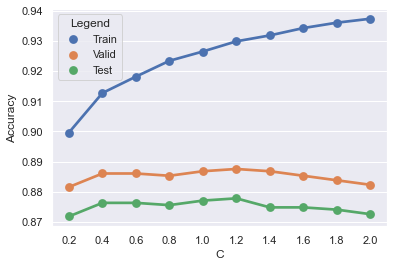

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

sns.set()

Cs = list(map(round, [i*.2 for i in range(1, 11)], [1]*10))
accs_train, accs_valid, accs_test = [], [], []

for c in Cs:
    clf = LogisticRegression(solver="lbfgs", C=c, max_iter=5000, verbose=0, n_jobs=-1)
    clf.fit(datasets["train"], labels["train"])

    accs_train.append(accuracy_score(labels["train"], clf.predict(datasets["train"])))
    accs_valid.append(accuracy_score(labels["valid"], clf.predict(datasets["valid"])))
    accs_test.append(accuracy_score(labels["test"], clf.predict(datasets["test"])))

accs_train_df = pd.DataFrame({
    "C": Cs,
    "Accuracy": accs_train,
    "Legend": "Train"})

accs_valid_df = pd.DataFrame({
    "C": Cs,
    "Accuracy": accs_valid,
    "Legend": "Valid"})

accs_test_df = pd.DataFrame({
    "C": Cs,
    "Accuracy": accs_test,
    "Legend": "Test"})

data = pd.concat([accs_train_df, accs_valid_df, accs_test_df])

ax = sns.pointplot(x="C", y="Accuracy", data=data, hue="Legend")
ax.set(xlabel="C", ylabel="Accuracy")
plt.show()